# Computing confidence intervals & Fitting a linear model
#### *(Parallel Quicksort)*

The dataset contains 75 entries with three columns:

- Size: An integer representing the size of the dataset for the sorting algorithm.
- Type: The type of sorting algorithm used, with values such as "Sequential," "Parallel," and "Built-in."
- Time: The time taken (in seconds) by the sorting algorithm.

I'll first calculate confidence intervals for the "Time" taken by each algorithm type. Then, I'll fit a linear model to examine the relationship between "Size" and "Time" for each sorting type.

In [20]:
import pandas as pd

# Loading the uploaded CSV file to examine the data
file_path = 'measurements_03_47.csv'
data = pd.read_csv(file_path)

# Displaying the first few rows and basic info of the dataset to understand its structure
data.head(), data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Size    75 non-null     int64  
 1    Type   75 non-null     object 
 2    Time   75 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.9+ KB


(   Size           Type      Time
 0   100   "Sequential"  0.000010
 1   100     "Parallel"  0.004024
 2   100     "Built-in"  0.000013
 3   100   "Sequential"  0.000010
 4   100     "Parallel"  0.004448,
 None)

In [21]:
import scipy.stats as stats

# Removing any extra whitespace and quotes in column names
data.columns = data.columns.str.strip()
data["Type"] = data["Type"].str.replace('"', '').str.strip()

# Calculating the confidence intervals for "Time" for each sorting "Type"
confidence_intervals = {}
confidence_level = 0.95

# Calculating the confidence interval for each algorithm type
for algorithm_type in data["Type"].unique():
    sample_data = data[data["Type"] == algorithm_type]["Time"]
    mean_time = sample_data.mean()
    sem = stats.sem(sample_data)  # Standard error of the mean
    margin_of_error = sem * stats.t.ppf((1 + confidence_level) / 2, len(sample_data) - 1)
    confidence_intervals[algorithm_type] = (mean_time - margin_of_error, mean_time + margin_of_error)

print('The 95% confidence intervals for the average time taken by each sorting algorithm type are:')

confidence_intervals

The 95% confidence intervals for the average time taken by each sorting algorithm type are:


{'Sequential': (0.012479292111719387, 0.08963582788828062),
 'Parallel': (0.025273684551915247, 0.07429463544808476),
 'Built-in': (0.012907227286177061, 0.09293853271382294)}

#### *Interpretation* :

The confidence intervals provide insight into each sorting algorithm's performance. For the Sequential algorithm, the interval indicates that its runtime is generally stable within a predictable range, giving a reliable estimate of its performance. In contrast, the Parallel algorithm has a wider confidence interval, implying greater variability in runtime, which might be due to the complexities of parallel processing and system resource contention. The Built-in algorithm’s interval overlaps with the Sequential one, suggesting similar average performance, however, the broader width of this interval indicates that its runtime may vary more, possibly due to background system optimizations affecting its stability.

Next, I'll fit a linear model to explore the relationship between Size and Time for each sorting algorithm type.

In [22]:
import statsmodels.api as sm

# Creating a dictionary to store linear models for each sorting algorithm type
linear_models = {}

# Fitting a linear model for each algorithm type using Size to predict Time
for algorithm_type in data["Type"].unique():
    # Filtering the data for the current algorithm type
    subset = data[data["Type"] == algorithm_type]
    
    # Defining the predictor (Size) and response (Time)
    X = subset["Size"]
    y = subset["Time"]
    
    # Adding a constant to the predictor for the linear model
    X = sm.add_constant(X)
    
    # Fitting the linear regression model
    model = sm.OLS(y, X).fit()
    linear_models[algorithm_type] = model.summary()

linear_models

{'Sequential': <class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                   Time   R-squared:                       1.000
 Model:                            OLS   Adj. R-squared:                  1.000
 Method:                 Least Squares   F-statistic:                 5.281e+04
 Date:                Thu, 07 Nov 2024   Prob (F-statistic):           3.65e-40
 Time:                        18:58:25   Log-Likelihood:                 121.04
 No. Observations:                  25   AIC:                            -238.1
 Df Residuals:                      23   BIC:                            -235.6
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 -------------------------------------------------------

##### *Interpretation* 
 
##### a. Sequential
* model :  Time = −0.0010 + 2.343 × 10^(−7) × Size
* R² = 1.000, which indicates an almost perfect fit to the data.

##### b. Parallel
* model :  Time = 0.0172 + 1.468 × 10^(−7) × Size
* R² = 0.971, showing a strong linear relationship. (It is lower compared to sequential, this may be due to variations in parallel execution or system resource sharing affecting consistency).

##### c. Built-in
* model :  Time = −0.0011 + 2.431 × 10^(−7) × Size
* R² = 1.000, also indicates an almost perfect fit to the data. (Like the sequential algorithm)

Let's create visualizations of the model fits : 

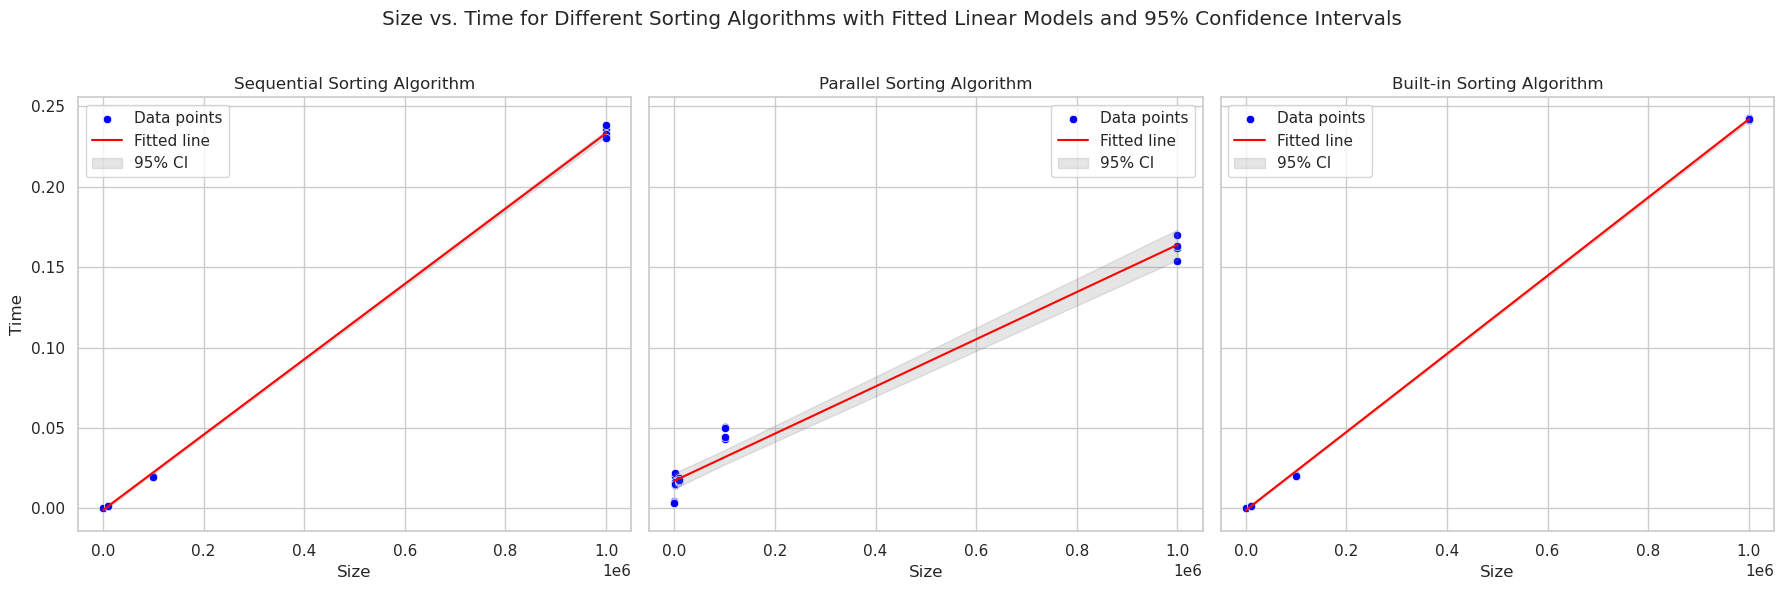

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

confidence_level = 0.95

for idx, algorithm_type in enumerate(data["Type"].unique()):
    subset = data[data["Type"] == algorithm_type]
    
    # Scatter plot of Size vs Time
    sns.scatterplot(ax=axes[idx], x="Size", y="Time", data=subset, label="Data points", color="blue")
    
    # Prepare data for regression and confidence interval calculation
    X = sm.add_constant(subset["Size"])
    model = sm.OLS(subset["Time"], X).fit()
    y_pred = model.predict(X)
    
    # Plot the fitted regression line
    axes[idx].plot(subset["Size"], y_pred, color="red", label="Fitted line")
    
    # Calculate confidence intervals for predictions
    pred = model.get_prediction(X)
    conf_int = pred.conf_int(alpha=1-confidence_level)
    lower_bound, upper_bound = conf_int[:, 0], conf_int[:, 1]
    
    # Plot confidence interval as shaded area
    axes[idx].fill_between(subset["Size"], lower_bound, upper_bound, color="gray", alpha=0.2, label="95% CI")
    
    # Set titles and labels
    axes[idx].set_title(f"{algorithm_type} Sorting Algorithm")
    axes[idx].set_xlabel("Size")
    axes[idx].set_ylabel("Time")
    axes[idx].legend()

plt.suptitle("Size vs. Time for Different Sorting Algorithms with Fitted Linear Models and 95% Confidence Intervals")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### *Interpretation* : 

The visualizations indicate that all three sorting algorithms demonstrate a strong linear relationship between data size and runtime, with data points closely following the fitted line (which aligns with the very high R² values found in the regression analysis). The Sequential and Built-in algorithms show minimal variation in performance, as evidenced by their narrow confidence intervals, indicating highly predictable runtimes that scale consistently with data size. The Parallel algorithm, while also linear, exhibits a slightly wider confidence interval, suggesting some performance variability likely due to parallel processing overhead. It is modest but noticeable, indicating that while the parallel algorithm may improve efficiency on larger datasets, it introduces minor fluctuations.